Put libraries here

In [20]:
import torch, os, pickle, sys,torch.nn.init as init, dgl, numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle

# from GAT import GAT
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
script_path = os.path.abspath("utils\\constans.py")  # Replace __file__ with the path to your script if in a notebook

# Determine the project directory by moving up two levels (adjust as needed)
project_directory = os.path.dirname(os.path.dirname(script_path))

print("Script Path:", script_path)
print("Project Directory:", project_directory)

Script Path: C:\Users\edayo\Downloads\4y2t\THSST-2\ug_thesis\ER_GAT\utils\constans.py
Project Directory: C:\Users\edayo\Downloads\4y2t\THSST-2\ug_thesis\ER_GAT


Code related to GAT

In [3]:

class DialogueGraphDataLoader(DataLoader):
    def __init__(self, node_features_list, edge_index_list, batch_size=1, shuffle=False):
        graph_dataset = DialogueGraphDataset(node_features_list, edge_index_list)
        super().__init__(graph_dataset, batch_size, shuffle, collate_fn=dialogue_graph_collate_fn)

class DialogueGraphDataset(Dataset):
    def __init__(self, node_features_list, edge_index_list):
        self.node_features_list = node_features_list
        self.edge_index_list = edge_index_list

    def __len__(self):
        return len(self.edge_index_list)

    def __getitem__(self, idx):
        return self.node_features_list[idx], self.edge_index_list[idx]

def dialogue_graph_collate_fn(batch):
    node_features_list, edge_index_list = zip(*batch)
    
    node_features_list_combined = []
    num_nodes_seen = 0

    for node_features, edge_index in zip(node_features_list, edge_index_list):
        # Assuming node_features is a tuple (text_embeddings, speakers_list)
        text_embeddings, speakers_list = node_features
        combined_features = (text_embeddings, speakers_list)

        node_features_list_combined.append(combined_features)

        # Translate the range of edge_index
        edge_index_list.append(edge_index + num_nodes_seen)
        num_nodes_seen += len(text_embeddings)

    # Merge the dialogue graphs into a single graph with multiple connected components
    node_features_combined = [torch.cat(features, 1) for features in zip(*node_features_list_combined)]
    edge_index = torch.cat(edge_index_list, 1)

    return node_features_combined, edge_index

# get one hot encoding to normalize values
def get_ohe(edge_types):
    # Number of classes
    one_hot_encoding = []

    # Convert to one-hot encoding
    for edge_type in edge_types:
        if edge_type==0:
            one_hot_encoding.append([1. ,0. ,0.])
        elif edge_type==1:
            one_hot_encoding.append([0. ,1. ,0.])
        elif edge_type==2:
            one_hot_encoding.append([0. ,0. ,1.])
    return torch.tensor(one_hot_encoding)

# print(edge_feats)

# print(sample[1]) #target: node 1
# output: [[1, -0.018013518303632736], [4, -0.013125997968018055]]
# print(sample[1][1]) #src: node 1
# output: [4, -0.013125997968018055]
# print(sample[1][1][1]) #attention val
# output: -0.013125997968018055
def get_inferred_edgetypes1(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    # the input is by dialog
    for target_node in dialog.values():
        if len(target_node) == 1:      
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
#             print(target_node)
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
    #         getting the relation type of a node
            for src_node in target_node[1:]:
#                 print(src_node)
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
#                     print(src_node)
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
#             print(len(edge_types), edge_index)
    #         print("=======")
    return inferred_edge_indices, inferred_edge_types


# [[0, [-0.006794655695557594, 0.11656633019447327, 0.10856685042381287]]]

# [[1, [0.47986578941345215, 0.24290838837623596, 0.20059877634048462]], [4, [-0.005781680811196566, 0.06976183503866196, -0.0009530335664749146]]]

# [[2, [0.4331742525100708, 0.20570839941501617, 0.18644499778747559]], [5, [0.4922890067100525, 0.21909664571285248, 0.09882635623216629]], [8, [-0.006040609907358885, 0.052320029586553574, 0.025565672665834427]]]

def get_inferred_edgetypes2(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
    #     print(sample_edgetypes[target_idx])
        # window size
        # print(len(sample_edgetypes[sample_idx]))
        num_edges = len(edges_target_nodes[target_idx])
        # display list of edges
        # print(sample_edgetypes[sample_idx][0])
        # highest observed attention score
        if num_edges == 1:
        #     print((max(sample_edgetypes[target_idx][0][1])))
        #     highest_attn_score = max(sample_edgetypes[target_idx][0][1])

    #         print(np.argmax(sample_edgetypes[target_idx][0][1]))
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
#           referencing edge_idx for edgetype
#             inferred_edge_types.append(sample_edge_types[edge_idx].tolist())
#           referencing egat prediction for edgetype
            inferred_edge_types.append(edgetype_idx)

#             print("Actual and Predicted EdgeType: ", sample_edge_types[edge_idx].tolist(), edgetype_idx)
        #     print(edge_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1,num_edges):
            #     print((max(sample_edgetypes[target_idx][sample_edge][1])))
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                # edge_type with highest attention
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
        #     comparison
#             inferred_edge_types.append(sample_edge_types[edge_idx].tolist())
            inferred_edge_types.append(edgetype_idx)

#             print("Actual and Predicted EdgeType: ", sample_edge_types[edge_idx].tolist(), edgetype_idx)

    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [4]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)  # Set your desired seed value
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
#         print("node_features.shape: ",node_features.shape, " edge_indices: ", edge_indices.shape)
#         print("edge_type.shape: ",  edge_type.shape)
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
#         print("h_linear.shape after linear_proj of node_features: ",h_linear.shape)
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
#         print("h_linear.shape after view: ",h_linear.shape)
        # Transpose dimensions of h_linear to match edge_type_embedding's shape
        h_linear = h_linear.permute(0, 2, 1)
#         print("h_linear.shape after permuting dimension: ",h_linear.shape)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)
#         print("edge_type_embedding.shape after transpose: ",edge_type_embedding.shape)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)
#         print("attention_scores..shape after matmul h_linear and edge_type_emb: ",attention_scores.shape)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

         # Weighted sum of neighbor node representations
#         print("attention_coefficients.shape after softmax: ",attention_coefficients.shape)
#       the one below is for edges
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)
#         the one below is for attention heads
#         updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).sum(dim=1)
#         print("updated_representation.shape after matmul of trasposed attn_coef and h_linear and sum at dim=1: ",updated_representation.shape)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    r"""
    
    Description
    -----------
    Apply Graph Attention Layer over input graph. EGAT is an extension
    of regular `Graph Attention Network <https://arxiv.org/pdf/1710.10903.pdf>`__ 
    handling edge features, detailed description is available in
    `Rossmann-Toolbox <https://pubmed.ncbi.nlm.nih.gov/34571541/>`__ (see supplementary data).
     The difference appears in the method how unnormalized attention scores :math:`e_{ij}`
     are obtain:
        
    .. math::
        e_{ij} &= \vec{F} (f_{ij}^{\prime})

        f_{ij}^{\prim} &= \mathrm{LeakyReLU}\left(A [ h_{i} \| f_{ij} \| h_{j}]\right)

    where :math:`f_{ij}^{\prim}` are edge features, :math:`\mathrm{A}` is weight matrix and 
    :math: `\vec{F}` is weight vector. After that resulting node features 
    :math:`h_{i}^{\prim}` are updated in the same way as in regular GAT. 
   
    Parameters
    ----------
    in_node_feats : int
        Input node feature size :math:`h_{i}`.
    in_edge_feats : int
        Input edge feature size :math:`f_{ij}`.
    out_node_feats : int
        Output nodes feature size.
    out_edge_feats : int
        Output edge feature size.
    num_heads : int
        Number of attention heads.
    bias : bool, optional
        If True, learns a bias term. Defaults: ``True``.
        
    Examples
    ----------
    >>> import dgl
    >>> import torch as th
    >>> from dgl.nn import EGATConv
    >>> 
    >>> num_nodes, num_edges = 8, 30
    >>>#define connections
    >>> u, v = th.randint(num_nodes, num_edges), th.randint(num_nodes, num_edges) 
    >>> graph = dgl.graph((u,v))    

    >>> node_feats = th.rand((num_nodes, 20)) 
    >>> edge_feats = th.rand((num_edges, 12))
    >>> egat = EGATConv(in_node_feats=20,
                          in_edge_feats=12,
                          out_node_feats=15,
                          out_edge_feats=10,
                          num_heads=3)
    >>> #forward pass                    
    >>> new_node_feats, new_edge_feats = egat(graph, node_feats, edge_feats)
    >>> new_node_feats.shape, new_edge_feats.shape
    ((8, 3, 12), (30, 3, 10))
    """
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):
        
        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        """
        Reinitialize learnable parameters.
        """
        torch.manual_seed(42)  # You can use any integer value as the seed
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        r"""
        Compute new node and edge features.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        nfeats : torch.Tensor
            The input node feature of shape :math:`(*, D_{in})`
            where:
                :math:`D_{in}` is size of input node feature,
                :math:`*` is the number of nodes.
        efeats: torch.Tensor
             The input edge feature of shape :math:`(*, F_{in})`
             where:
                 :math:`F_{in}` is size of input node feauture,
                 :math:`*` is the number of edges.
        get_attention : bool, optional
                Whether to return the attention values. Default to False.
            
        Returns
        -------
        pair of torch.Tensor
            node output features followed by edge output features
            The node output feature of shape :math:`(*, H, D_{out})` 
            The edge output feature of shape :math:`(*, H, F_{out})`
            where:
                :math:`H` is the number of heads,
                :math:`D_{out}` is size of output node feature,
                :math:`F_{out}` is size of output edge feature.            
        """
        
        with graph.local_scope():
            # TODO allow node src and dst feats
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            # calc edge attention
            # same trick way as in dgl.nn.pytorch.GATConv, but also includes edge feats
            # https://github.com/dmlc/dgl/blob/master/python/dgl/nn/pytorch/conv/gatconv.py#L297
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            #graph.edata.update({'f_fij' : f_fij})
            # add ni, nj factors
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            # add fij to node factor
            f_out = graph.edata.pop('f_tmp') + f_fij 
            if self.bias is not None:
                f_out+= self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            # compute attention factor
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            # calc weighted sum 
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'),
                            fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


<h3>Methods definition

In [5]:
def create_node_pairs_list(start_idx, end_idx):
    # Initialize an empty list to store pairs
    list_node_i = []
    list_node_j = []
#     node_pairs_dict = {}
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= 3)  and (i+val <= end_idx):
            target_idx = i+val
#                 print(target_idx)
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
#                 node_pairs_dict[i] = target_idx
            val = val+1
    
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}

    # Iterate through pairs of nodes
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]

#         # Add source node to target node's neighbors
#         if target_node not in adjacency_list_dict:
#             adjacency_list_dict[target_node] = [source_node]
#         else:
#             adjacency_list_dict[target_node].append(source_node)

        # Add target node to source node's neighbors
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)

    return adjacency_list_dict
# print(ranges[:1])

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    
    for i in range(dialogs_len): #2140 dialogs
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
#         print(i, " th dialogue")
#         print(i, dialog_speakers)
        for j in range(dialog_len): #num utterances
            src_node = dialog_nodes_pairs[j] # j = key = src node
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k] # k = value = targ node
                # edge_types = torch.tensor([0, 1, 2]) 
                # 0: cur-self, 1: past-self, 2: past-other/past-inter
                                
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
#                     print("This is 0 ", node_i_idx, node_j_idx)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
#                         print("This is 1 ", node_i_idx, node_j_idx)
                    else:
                        edge_type_list.append(2)
#                         print("This is 2 ", node_i_idx, node_j_idx)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))  
                    
    return whole_edge_type_list

In [6]:
checkFile = os.path.isfile("data/dump/speaker_encoder.pkl")
encoded_speaker_list = []
if checkFile is False:
    print("Run first the prototype_context_encoder to generate this file")
else:
    file = open('data/dump/speaker_encoder.pkl', "rb")
    encoded_speaker_list, ranges = pickle.load(file)
    file.close()

In [7]:
file_path = 'embed/updated_representation_list.pkl'

# Load the list from the file using pickle
with open(file_path, 'rb') as file:
    updated_representations = pickle.load(file)

<h3> Getting the updated representation

In [8]:
edge_indices = get_all_adjacency_list(ranges)
edge_types = get_all_edge_type_list(edge_indices, encoded_speaker_list)
edge_indices = get_all_adjacency_list(ranges, key=1)

In [9]:
# i = 38
# print(updated_representations[i].shape)
print("Number of edges: ", len(edge_indices[0][0]))
print(edge_indices[0])

Number of edges:  50
tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,
          4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
          9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 12, 12, 13],
        [ 0,  1,  2,  3,  1,  2,  3,  4,  2,  3,  4,  5,  3,  4,  5,  6,  4,  5,
          6,  7,  5,  6,  7,  8,  6,  7,  8,  9,  7,  8,  9, 10,  8,  9, 10, 11,
          9, 10, 11, 12, 10, 11, 12, 13, 11, 12, 13, 12, 13, 13]])


<h4>Instantiating the GAT (first implementation)

In [10]:
num_in_features = 300
num_out_features = 300
num_heads = 4
num_edge_types = 3

gat_layer = GATLayerWithEdgeType(num_in_features, num_out_features, num_heads, num_edge_types)

Infering edge type of nodes from 1 example

In [11]:
i = 0 #dialogue id
h_prime, attention_coef = gat_layer((updated_representations[i], edge_indices[i]), edge_types[i])
# print(f"dialogue_representation[{i}] shape:", updated_representations[i].shape)
# print("Attention coef shape:", attention_coef.shape)
print("h_prime shape: ", h_prime.shape, "attention_coef shape: ", attention_coef.shape)
# source node
# index represent the edge
target_nodes = edge_indices[i][1].tolist() #first idx represent dialogue id

sample = {}
sample_edgetypes = []
for target_i in set(target_nodes):
    sample[target_i] = []
# print(target_nodes)
for target_node, idx in zip(target_nodes, range(len(target_nodes))):
#     print(target_node, idx)
    sample[target_node].append([idx, h_prime[target_node][idx].tolist()])

list_edge_idx, inferred_edgetypes = get_inferred_edgetypes1(sample, edge_types[i])
sample_edgetypes.append(inferred_edgetypes)

# print(edge_types[i]) #candidate edgetypes
# print(edge_indices[i]) #first row is the src node idx and second row is the target node idx
# print(sample_edgetypes) #inferred edge types 

h_prime shape:  torch.Size([14, 50]) attention_coef shape:  torch.Size([14, 300, 50])


<h4>Exploratory Data Analysis

In [12]:
file = open('data/dump/label_decoder.pkl', 'rb')
label_decoder = pickle.load(file)
file.close()
label_decoder = list(label_decoder.values())
print(label_decoder)

['neutral', 'anger', 'joy', 'fear', 'disgust', 'sadness', 'surprise']


In [13]:
checkFile = os.path.isfile("data/dump/train_labels.pkl")

if checkFile is False:
    print("Please run the context_encoder nodebook to save label file")
    
else:
    file = open('data/dump/train_labels.pkl', 'rb')
    y_train = pickle.load(file)
    file.close()

Graph visualization (for W8)

In [14]:
# from pyvis.network import Network

# # Create a new Pyvis Network instance
# net = Network()

# # Add nodes with labels and names
# nodes = [(0, 'Node 0'), (1, 'Node 1'), (2, 'Node 2'), (3, 'Node 3')]
# labels = [0, 1, 0, 1]  # Example labels for nodes
# color_mapping = {0: 'red', 1: 'blue'}  # Define color mapping for labels
# for node_id, node_name, label in zip(range(len(nodes)), nodes, labels):
#     net.add_node(node_id, label=node_name[1], color=color_mapping[label])

# # Add edges with weights and arrows
# edges = [(0, 1, 0.5), (1, 2, 0.8), (2, 3, 0.6), (3, 0, 0.7)]  # Example edges with weights
# for source, target, weight in edges:
#     net.add_edge(source, target, value=weight, arrows='to')

# # Set options for the network visualization
# net.set_options("""
# var options = {
#   "edges": {
#     "arrows": {
#       "to": {
#         "enabled": true
#       }
#     }
#   },
#   "nodes": {
#     "font": {
#       "size": 20
#     }
#   }
# }
# """)

# # Show the network visualization
# net.show("graph.html", notebook=False)


<h5>Unsupervised Visualizarion

<h6> Visualize 1 instance then scale up

In [15]:
# Assuming h_prime contains the node embeddings
utt_size=13
labels = torch.tensor(y_train[:utt_size+1])

cherrypicked_nodes = []
for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
    cherrypicked_nodes.append(attention_coef[src_idx, :, edge_idx].tolist())
cherrypicked_nodes = torch.tensor(cherrypicked_nodes)

In [16]:
cherrypicked_nodes.shape

torch.Size([14, 300])

C:\Users\edayo\AppData\Local\Temp\ipykernel_6448\1138302530.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_prime_np = torch.tensor(cherrypicked_nodes).numpy()


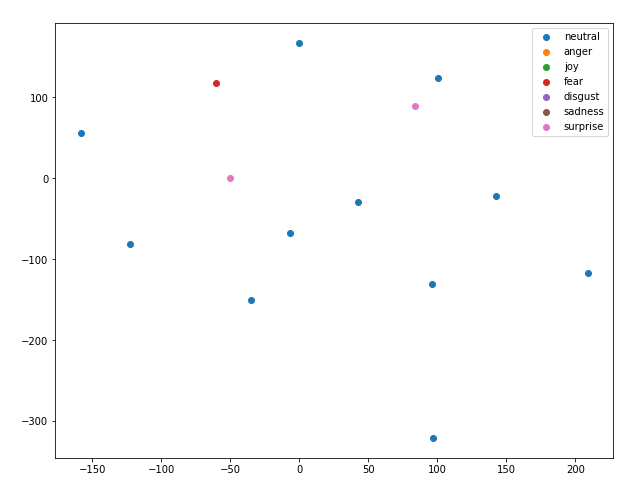

In [17]:
# Convert tensor to numpy array
h_prime_np = torch.tensor(cherrypicked_nodes).numpy()

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
h_prime_tsne = tsne.fit_transform(h_prime_np)

# Plot the node embeddings with different colors for each label
plt.figure(figsize=(10, 8))
for label, emotion in zip(range(len(label_decoder)),label_decoder): 
    indices = (labels == label).nonzero().squeeze()
    plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
plt.title('Node Embeddings Visualization (t-SNE)', color="white")
plt.xlabel('Dimension 1', color="white")
plt.ylabel('Dimension 2', color="white")
plt.legend()
plt.show()

<h6>Now for all train data

In [22]:
## save the data in pickle format ##
checkFile = os.path.isfile("data/dump/1st_gat.pkl")
if checkFile is False:
    
    "Start of getting output of 1st GAT"
    all_inferred_edgetypes = []
    list_all_edge_idx = []
    cherrypicked_nodes = []
    for dialog, dialog_id in zip(updated_representations, range(len(updated_representations))):
        h_prime, attention_coef = gat_layer((dialog, edge_indices[dialog_id]), edge_types[dialog_id])
    #     all_attention
        # print(f"dialogue_representation[{i}] shape:", updated_representations[i].shape)
        # print("Attention coef shape:", attention_coef.shape)
        # print("h_prime shape:", h_prime.shape)
        # source node
        # index represent the edge
        target_nodes = edge_indices[dialog_id][1].tolist() #first idx represent dialogue id

        sample_edgetypes = {}
        for i in set(target_nodes):
            sample_edgetypes[i] = []

        for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
            sample_edgetypes[target_node].append([edge_idx, h_prime[target_node][edge_idx].tolist()])
    #     print(len(sample_edgetypes), dialog_id)
        list_edge_idx, inferred_edgetypes = get_inferred_edgetypes1(sample_edgetypes,  edge_types[dialog_id])
        list_all_edge_idx.append(list_edge_idx)
        all_inferred_edgetypes.append(inferred_edgetypes)


        for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
            cherrypicked_nodes.append(attention_coef[src_idx, :, edge_idx].tolist())

    #     print(dialog_id)
    cherrypicked_nodes = torch.tensor(cherrypicked_nodes)
    cherrypicked_nodes.shape
    "end of getting output of 1st GAT"
    pickle.dump([cherrypicked_nodes, all_inferred_edgetypes],
            open('data/dump/1st_gat', 'wb'))
    
else:
    file = open('data/dump/1st_gat.pkl', 'rb')
    cherry_picked_nodes, all_inferred_edgetypes = pickle.load(file)
    file.close()


In [23]:
# Convert tensor to numpy array
labels = torch.tensor(y_train) 
h_prime_np = torch.tensor(cherrypicked_nodes).numpy()

C:\Users\edayo\AppData\Local\Temp\ipykernel_6448\394207145.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_prime_np = torch.tensor(cherrypicked_nodes).numpy()


In [26]:
runTSNE = 0

In [27]:
if runTSNE:
    # List of perplexity values to loop over
    perplexity_values = [30, 100]

    # Loop over each perplexity value
    for perplexity in perplexity_values:
        # Initialize t-SNE with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the data using t-SNE
        h_prime_tsne = tsne.fit_transform(h_prime_np)

        # Plot the node embeddings with different colors for each label
        plt.figure(figsize=(10, 8))
        for label, emotion in zip(range(len(label_decoder)), label_decoder): 
            indices = (labels == label).nonzero().squeeze()
            plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
        plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
        plt.xlabel('Dimension 1', color="white")
        plt.ylabel('Dimension 2', color="white")
        plt.legend()
        plt.show()

Scale up 'till you get the edgetypes of all train dialogs 

In [28]:
df_eda = pd.DataFrame(
    {'edgetype': flatten_extend(all_inferred_edgetypes),
     'label': y_train,
    })

In [29]:
CrosstabResult=pd.crosstab(index=df_eda['edgetype'],columns=df_eda['label'])
print(CrosstabResult)

# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)
# H0: The variables are not correlated with each other.

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
if ChiSqResult[1] > 0.05:
    print("Variables are not correlated with each other")
else:
    print("Two variables are correlated")

label        0     1     2    3    4    5    6
edgetype                                      
0         2218   407   941   97  117  277  591
2         3742  1093  1371  241  247  599  899
The P-Value of the ChiSq Test is: 6.372109133776597e-20
Two variables are correlated


Below is a sample usage of GAT (second implementation)

In [30]:
num_nodes = 8
num_edges = 30
#define connections
u = torch.randint(num_nodes, (num_edges,))
print("u: ", u)
v = torch.randint(num_nodes, (num_edges,)) 
print("v: ", v)
graph = dgl.graph((u,v))    
print(graph)
node_feats = torch.rand((num_nodes, 20)) 
print("node_feats.shape: ", node_feats.shape)
edge_feats = torch.rand((num_edges, 12))
print("edge_feats.shape: ", edge_feats.shape)


u:  tensor([3, 5, 5, 1, 7, 3, 4, 0, 3, 1, 5, 4, 3, 0, 0, 2, 2, 6, 1, 7, 3, 3, 7, 6,
        5, 5, 6, 5, 2, 3])
v:  tensor([6, 3, 7, 0, 2, 4, 2, 6, 4, 0, 6, 1, 3, 0, 3, 5, 1, 1, 0, 1, 4, 1, 3, 3,
        6, 3, 6, 3, 4, 7])
Graph(num_nodes=8, num_edges=30,
      ndata_schemes={}
      edata_schemes={})
node_feats.shape:  torch.Size([8, 20])
edge_feats.shape:  torch.Size([30, 12])


In [31]:
#use as regular torch/dgl layer work similar as GATConv from dgl library
# egat = EGATConv(in_node_feats=num_node_feats,
#                 in_edge_feats=num_edge_feats,
#                 out_node_feats=10,
#                 out_edge_feats=10,
#                 num_heads=3)

In [32]:
# new_node_feats, new_edge_feats = egat(graph, node_feats, edge_feats)
#new_node_feats.shape = (*, num_heads, out_node_feats)
#new_eode_feats.shape = (*, num_heads, out_edge_feats)

In [33]:
egat = EGATConv(in_node_feats=300,
                    in_edge_feats=3,
                    out_node_feats=300,
                    out_edge_feats=3,
                    num_heads=4)

In [34]:
## save the data in pickle format ##
checkFile = os.path.isfile("data/dump/2nd_gat.pkl")
if checkFile is False:
    "Start of getting output of 1st GAT"
    inferred_edgetypes2 = []
    all_node_feats = []
    for dialog_id in range(len(updated_representations)):
        graph = dgl.graph((edge_indices[dialog_id][0],edge_indices[dialog_id][1]))    
        edge_feats = get_ohe(edge_types[dialog_id])
        new_node_feats, new_edge_feats = egat(graph, updated_representations[dialog_id], edge_feats)
    #     print(new_node_feats.shape, new_edge_feats.shape)

        target_nodes = edge_indices[dialog_id][1].tolist() #first idx represent dialogue id
        mean_edge_feats = new_edge_feats.mean(dim=1)

        all_node_feats.append(new_node_feats.mean(dim=1).tolist())

        sample_edgetypes = {}
        for i in set(target_nodes):
            sample_edgetypes[i] = []

        for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
            sample_edgetypes[target_node].append([edge_idx, mean_edge_feats[edge_idx].tolist()])

        sample_edgetypes = get_inferred_edgetypes2(sample_edgetypes, 
                                edge_types[dialog_id], 
                                len(updated_representations[dialog_id]),
                                dialog_id)
        inferred_edgetypes2.append(sample_edgetypes)

    all_node_feats = torch.tensor(flatten_extend(all_node_feats))

    "end of getting output of 2nd GAT"
    pickle.dump([all_node_feats, inferred_edgetypes2],
            open('data/dump/2nd_gat', 'wb'))
    
else:
    file = open('data/dump/2nd_gat.pkl', 'rb')
    all_node_feats, inferred_edgetypes2 = pickle.load(file)
    file.close()

In [35]:
df_eda2 = pd.DataFrame(
    {'edgetype': flatten_extend(inferred_edgetypes2),
     'label': y_train,
    })

In [36]:
CrosstabResult2=pd.crosstab(index=df_eda2['edgetype'],columns=df_eda2['label'])
print(CrosstabResult2)

# Performing Chi-sq test
ChiSqResult2 = chi2_contingency(CrosstabResult2)

# P-Value is the Probability of H0 being True
# If P-Value > 0.05 then only we Accept the assumption(H0)
# H0: The variables are not correlated with each other.

print('The P-Value of the ChiSq Test is:', ChiSqResult2[1])
if ChiSqResult2[1] > 0.05:
    print("Variables are not correlated with each other")
else:
    print("Two variables are correlated")

label        0    1     2    3    4    5    6
edgetype                                     
0         3657  971  1333  230  205  548  894
1         2207  499   920  105  155  321  545
2           96   30    59    3    4    7   51
The P-Value of the ChiSq Test is: 6.228942926996122e-09
Two variables are correlated


Testing on 1 dialog data before scaling up

In [37]:
dialog_id=0

graph = dgl.graph((edge_indices[dialog_id][0],edge_indices[dialog_id][1]))    
edge_feats = get_ohe(edge_types[dialog_id])
new_node_feats, new_edge_feats = egat(graph, updated_representations[dialog_id], edge_feats)
print(new_node_feats.shape, new_edge_feats.shape)
#target_nodes = edge_indices[dialog_id][1].tolist() #first idx represent dialogue id
h_prime_mean = new_node_feats.mean(dim=1)
utt_size=13
labels = torch.tensor(y_train[:utt_size+1])

torch.Size([14, 4, 300]) torch.Size([50, 4, 3])


In [38]:
print(new_node_feats.shape)
print(new_edge_feats.shape)

torch.Size([14, 4, 300])
torch.Size([50, 4, 3])


C:\Users\edayo\AppData\Local\Temp\ipykernel_6448\4041947391.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_prime_np = torch.tensor(h_prime_mean).numpy()


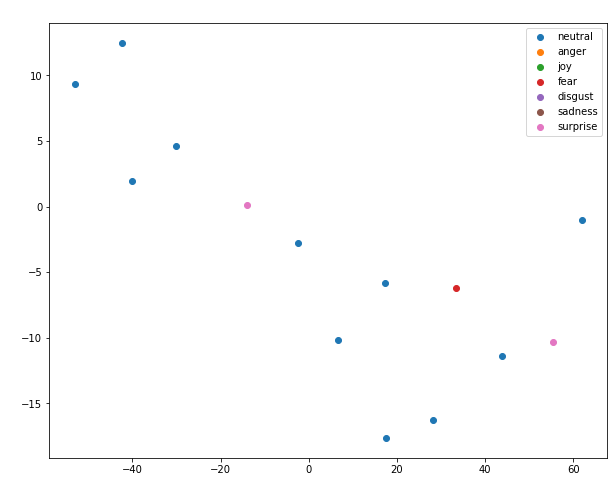

In [39]:
# Convert tensor to numpy array
h_prime_np = torch.tensor(h_prime_mean).numpy()

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
h_prime_tsne = tsne.fit_transform(h_prime_np)

# Plot the node embeddings with different colors for each label
plt.figure(figsize=(10, 8))
for label, emotion in zip(range(len(label_decoder)),label_decoder): 
    indices = (labels == label).nonzero().squeeze()
    plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
plt.title('Node Embeddings Visualization (t-SNE)', color="white")
plt.xlabel('Dimension 1', color="white")
plt.ylabel('Dimension 2', color="white")
plt.legend()
plt.show()

In [40]:
all_node_feats.shape

torch.Size([12840, 300])

In [41]:
runTSNE = 0

In [42]:
if runTSNE:
    # Convert tensor to numpy array
    h_prime_np = torch.tensor(all_node_feats).numpy()
    labels = torch.tensor(y_train)
    # List of perplexity values to loop over
    perplexity_values = [30, 100]

    # Loop over each perplexity value
    for perplexity in perplexity_values:
        # Initialize t-SNE with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the data using t-SNE
        h_prime_tsne = tsne.fit_transform(h_prime_np)
        print(h_prime_tsne.shape)
        # Plot the node embeddings with different colors for each label
        plt.figure(figsize=(10, 8))
        for label, emotion in zip(range(len(label_decoder)), label_decoder): 
            indices = (labels == label).nonzero().squeeze()
            plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
        plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
        plt.xlabel('Dimension 1', color="white")
        plt.ylabel('Dimension 2', color="white")
        plt.legend()
        plt.show()

Store the 2nd GAT output